# Notebook to Go Through the Steps in Calculating the Boundary Conditions #

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import importlib

import pandas as pd

import xarray as xr

import PI_BOUND_COND as pibc

SyntaxError: invalid syntax (PI_BOUND_COND.py, line 36)

In [ ]:
importlib.reload(pibc)

### Choose our Day (September 8, 2015 and our profile #10)
Read in the LiveOcean Boundary Conditions

In [3]:
model_year = 2015
ds = xr.open_dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2015m09d08.nc')

In [4]:
ds = pibc.calculate_sigma(ds)
ds, conversion_uMolar_to_umolkg = pibc.change_to_umol_kg(ds)

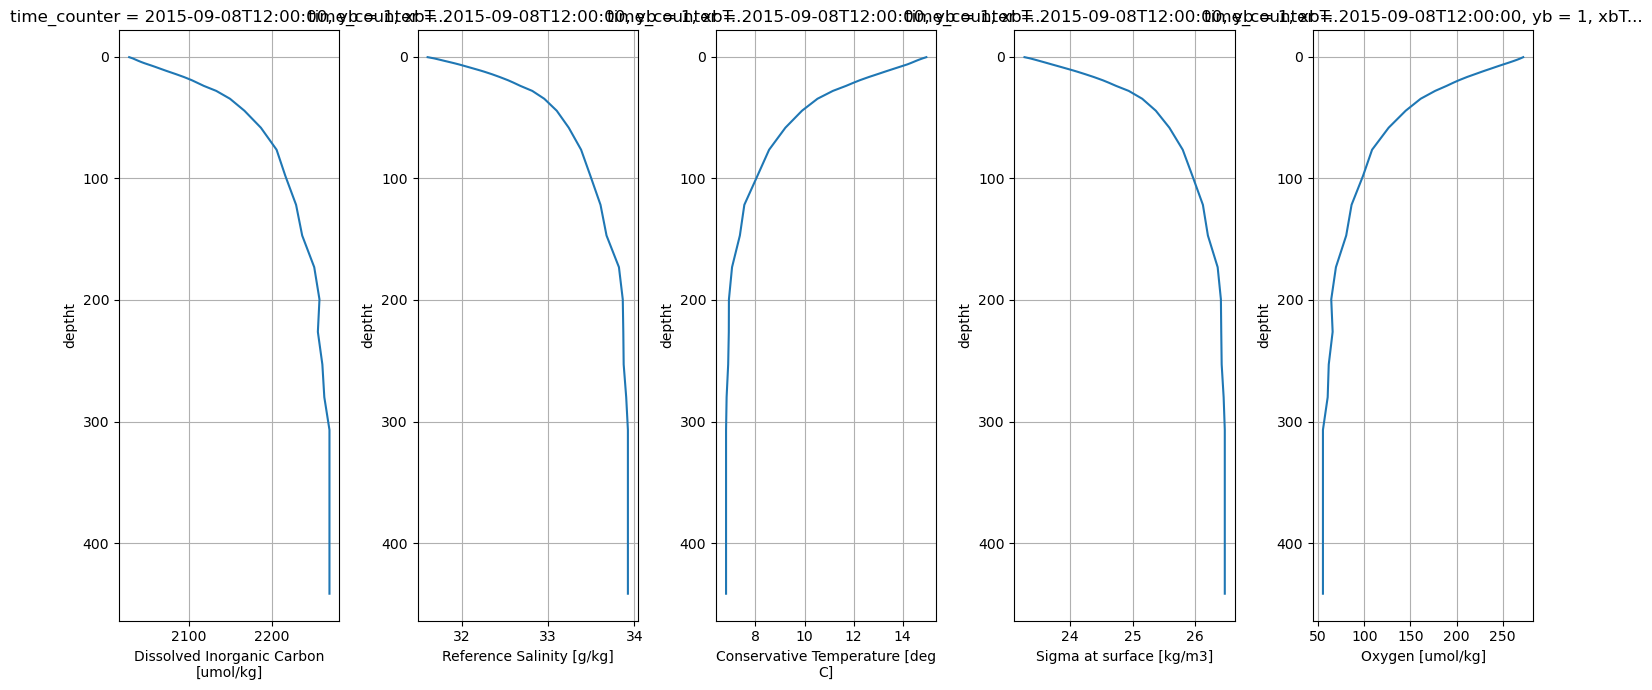

In [5]:
# Plot
fig, axs = plt.subplots(1, 5, figsize=(15, 7))
ds.DIC[0, :, 0, 10].plot(ax = axs[0], y='deptht', yincrease=False);
ds.vosaline[0, :, 0, 10].plot(ax = axs[1], y='deptht', yincrease=False);
ds.votemper[0, :, 0, 10].plot(ax = axs[2], y='deptht', yincrease=False);
ds.sigma[0, :, 0, 10].plot(ax = axs[3], y='deptht', yincrease=False);
ds.OXY[0, :, 0, 10].plot(ax = axs[4], y='deptht', yincrease=False);

for ax in axs:
    ax.grid()
fig.tight_layout();

## Step 1 Find when isopycnal last at surface

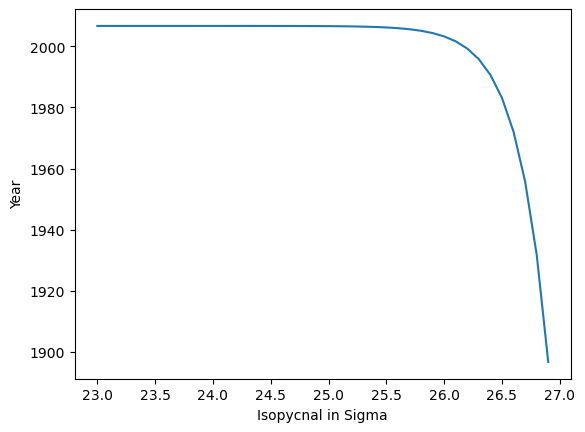

In [6]:
# plot
params0 = 0.1301889490932413
params1 = 3.8509914822057825
params2 = 8.301166081413104 + model_year - 2015
ssigmas = np.arange(23, 27, 0.1)
pycnal_last_at_surface = 2015 - (params0 * np.exp(-params1 * (25.15 - ssigmas)) + params2)
plt.plot(ssigmas, pycnal_last_at_surface);
plt.ylabel('Year')
plt.xlabel('Isopycnal in Sigma');

Image with the Data 
![title](../../../analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/FigureS8_Jarnikova_PI.png)

I note that the fit is poor for sigma < 25: but we don't use it for that, so all okay

In [7]:
ds = pibc.calculate_year_isopyncal_surface(ds, model_year)

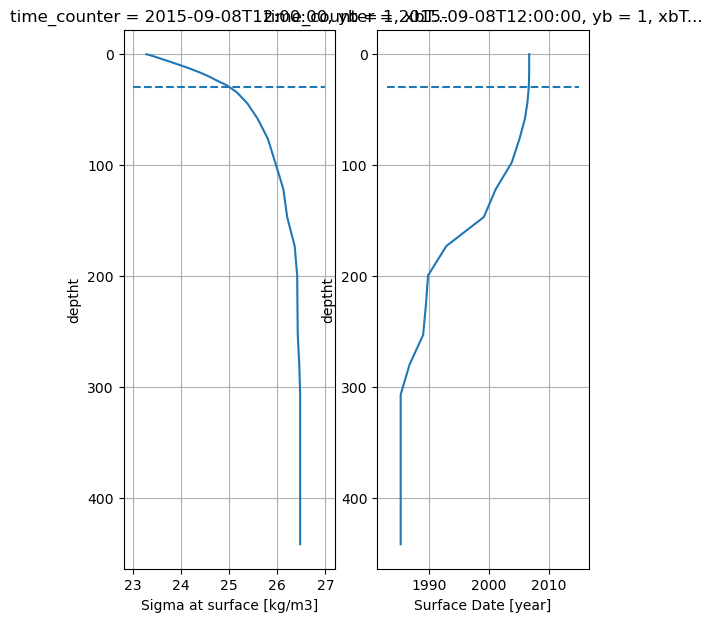

In [8]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15/5*2, 7))
ds.sigma[0, :, 0, 10].plot(ax = axs[0], y='deptht', yincrease=False);
ds.pycnal_last_at_surface[0, :, 0, 10].plot(ax = axs[1], y='deptht', yincrease=False);

for ax in axs:
    ax.grid();
axs[0].plot([23, 27], [30, 30], '--', color='tab:blue')
axs[1].plot([1983, 2015], [30, 30], '--', color='tab:blue');

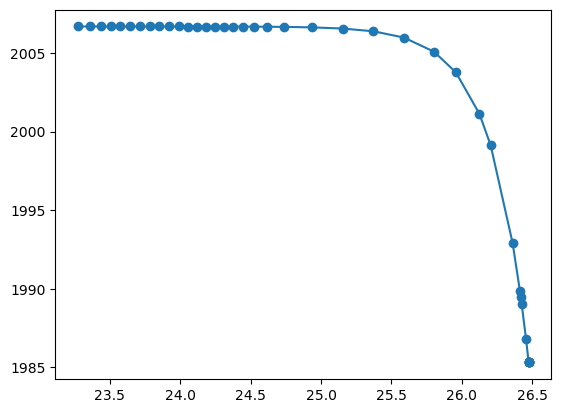

In [9]:
#plot
plt.plot(ds.sigma[0, :, 0, 10], ds.pycnal_last_at_surface[0, :, 0, 10], 'o-');

## Step 2 Find pCO2 at Surface that Year ##

In [10]:
# plot/ check it out
co2_rec = pd.read_csv('../../../analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/lawdome_maunaloa.csv')
print (co2_rec)
years = [1833.2, 1932, 2017]
for year in years:
    print (co2_rec.iloc[np.argmin(np.abs(co2_rec['YEAR'] - year))]['PPMCO2'])

     YEAR  PPMCO2 Unnamed: 2
0    1832  284.30           
1    1833  284.10           
2    1834  284.00           
3    1835  283.80           
4    1836  283.70           
..    ...     ...        ...
182  2014  398.65        NaN
183  2015  400.83        NaN
184  2016  404.24        NaN
185  2017  406.55        NaN
186  2018  408.52        NaN

[187 rows x 3 columns]
284.1
308.2
406.55


In [11]:
ds = pibc.calculate_atpco2_for_year(ds)

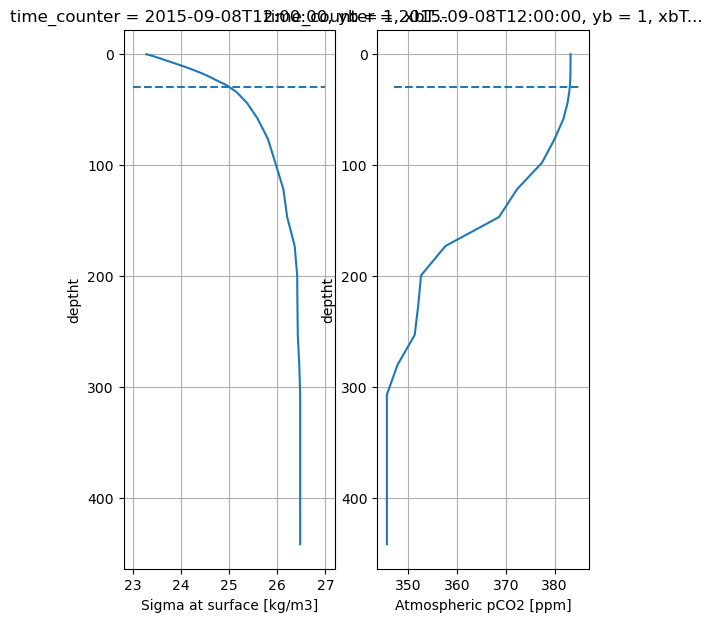

In [12]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15/5*2, 7))
ds.sigma[0, :, 0, 10].plot(ax = axs[0], y='deptht', yincrease=False);
ds.atpco2[0, :, 0, 10].plot(ax = axs[1], y='deptht', yincrease=False);

for ax in axs:
    ax.grid();
axs[0].plot([23, 27], [30, 30], '--', color='tab:blue')
axs[1].plot([347, 385], [30, 30], '--', color='tab:blue');

Less kinks than Tereza as I have no year truncation.

## Step 3 Find AOU for Water Masses ##

We would expect a different ratio than Redfield (Anderson & Sarmiento, 1994)
Anderson, L. A., & Sarmiento, J. L. (1994). Redfield ratios of remineralization determined by nutrient data analysis. Global Biogeochemical Cycles, 8(1), 65â€“80. https://doi.org/10.1029/93GB03318

In [13]:
ds = pibc.calculate_AOU_in_Carbon(ds)

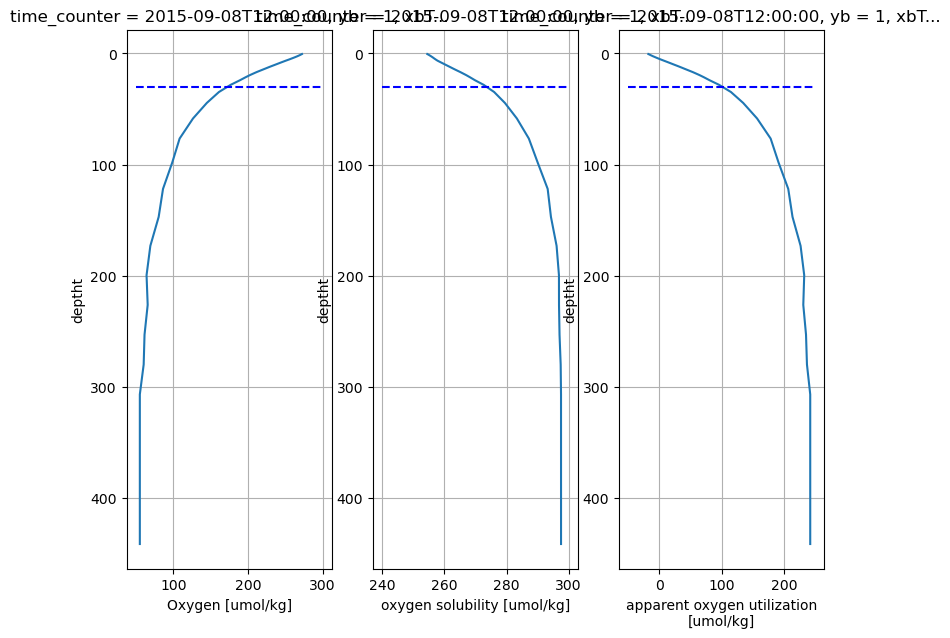

In [14]:
# plot
fig, axs = plt.subplots(1, 3, figsize=(15/5*3, 7))
ds.OXY[0, :, 0, 10].plot(ax = axs[0], y='deptht', yincrease=False);
ds.osol[0, :, 0, 10].plot(ax = axs[1], y='deptht', yincrease=False);
ds.AOU[0, :, 0, 10].plot(ax = axs[2], y='deptht', yincrease=False);

for ax in axs:
    ax.grid();
axs[0].plot([50, 300], [30, 30], '--', color='b')
axs[1].plot([240, 300], [30, 30], '--', color='b');
axs[2].plot([-50, 250], [30, 30], '--', color='b');

## Step 4 Find preformed DIC ##

In [16]:
ds = pibc.calculate_preformed_DIC(ds)

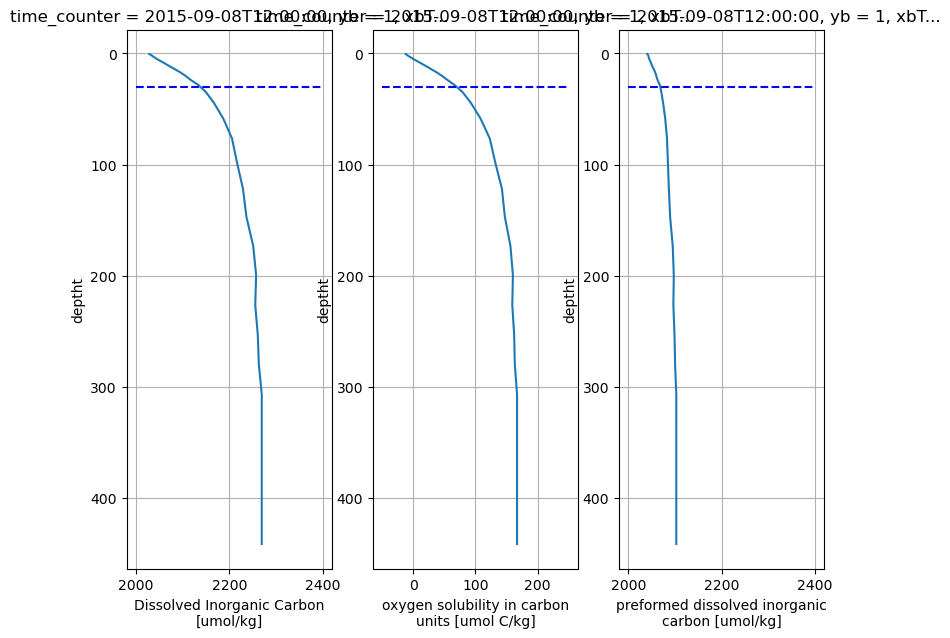

In [17]:
# plot
fig, axs = plt.subplots(1, 3, figsize=(15/5*3, 7))
ds.DIC[0, :, 0, 10].plot(ax = axs[0], y='deptht', yincrease=False);
ds.AOU_stoich[0, :, 0, 10].plot(ax = axs[1], y='deptht', yincrease=False);
ds.preformed_DIC[0, :, 0, 10].plot(ax = axs[2], y='deptht', yincrease=False);

for ax in axs:
    ax.grid();
axs[0].plot([2000, 2400], [30, 30], '--', color='b')
axs[1].plot([-50, 250], [30, 30], '--', color='b');
axs[2].plot([2000, 2400], [30, 30], '--', color='b');

## Step 4b Find Preformed pCO2 ##

Use CO2sys as we need to go back as well and need to be consistent

https://pyco2sys.readthedocs.io/en/latest/

and in particular example 2  https://github.com/mvdh7/PyCO2SYS-examples/blob/master/CO2SYSExample2.ipynb

In [18]:
ds = pibc.calculate_preformed_pCO2(ds, conversion_uMolar_to_umolkg) # conversion factor is for Si and PO4(NO3) which we are not using anyway

68.9881470582269


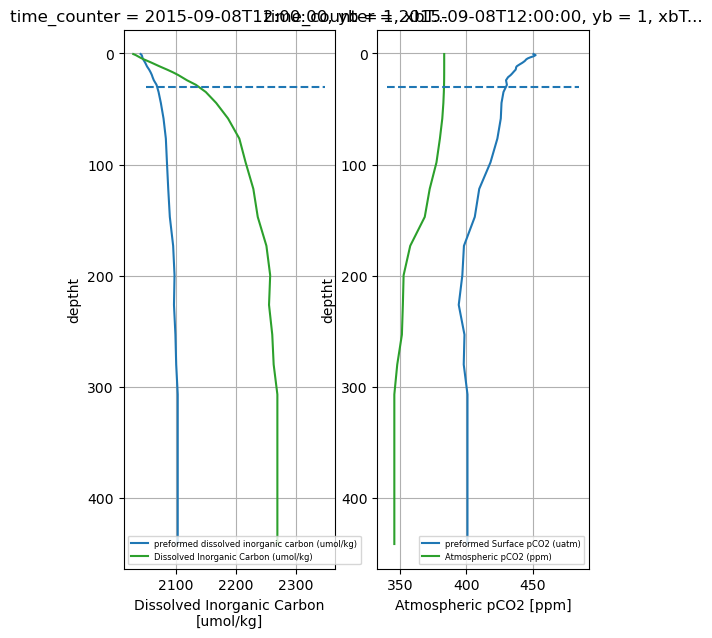

In [19]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15/5*2, 7))
ds.preformed_DIC[0, :, 0, 10].plot(ax=axs[0], y='deptht', yincrease=False, 
                        label=f'{ds.preformed_DIC.attrs["long_name"]} ({ds.preformed_DIC.attrs["units"]})')           
ds.DIC[0, :, 0, 10].plot(ax=axs[0], y='deptht', yincrease=False, color='tab:green', 
                         label=f'{ds.DIC.attrs["long_name"]} ({ds.DIC.attrs["units"]})')
ds.preformed_pco2[0, :, 0, 10].plot(ax=axs[1], y='deptht', yincrease=False, 
                                    color='tab:blue', 
                        label=f'{ds.preformed_pco2.attrs["long_name"]} ({ds.preformed_pco2.attrs["units"]})')
ds.atpco2[0, :, 0, 10].plot(ax=axs[1], y='deptht', yincrease=False, color='tab:green',
                         label=f'{ds.atpco2.attrs["long_name"]} ({ds.atpco2.attrs["units"]})');

for ax in axs:
    ax.grid();
    ax.legend(prop={'size': 6});
axs[0].plot([2050, 2350], [30, 30], '--', color='tab:blue')
axs[1].plot([340, 485], [30, 30], '--', color='tab:blue');

print (np.max(ds.preformed_pco2[0, :, 0, 10] - ds.atpco2[0, :, 0, 10]).values)

Quite a big difference but early September is probably near maximum

## Step 5 Find Dis-equilibrium pCO2 ##


In [20]:
ds = pibc.calculate_disequ_pCO2(ds)

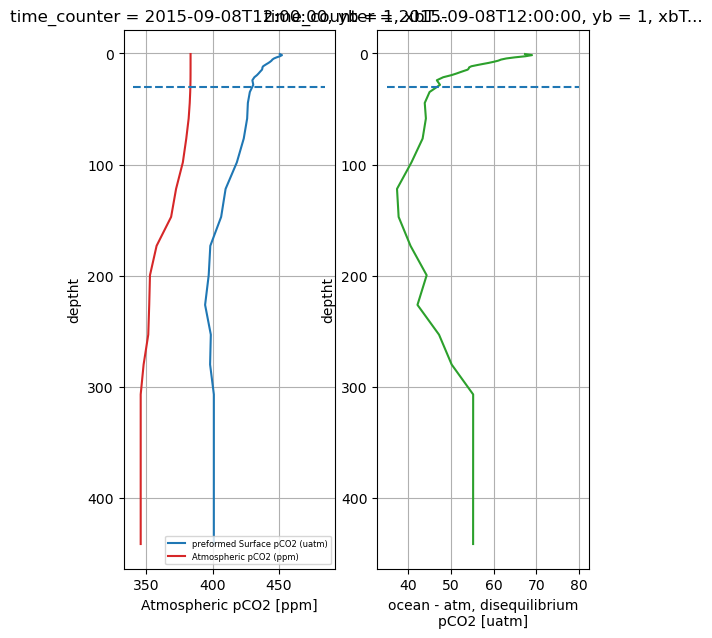

In [21]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15/5*2, 7))
ds.preformed_pco2[0, :, 0, 10].plot(ax=axs[0], y='deptht', yincrease=False, color='tab:blue',
                        label=f'{ds.preformed_pco2.attrs["long_name"]} ({ds.preformed_pco2.attrs["units"]})')
ds.atpco2[0, :, 0, 10].plot(ax=axs[0], y='deptht', yincrease=False, color='tab:red',
                         label=f'{ds.atpco2.attrs["long_name"]} ({ds.atpco2.attrs["units"]})');   

ds.diseqPCO2[0, :, 0, 10].plot(ax=axs[1], y='deptht', yincrease=False, color='tab:green');

for ax in axs:
    ax.grid();
axs[0].legend(prop={'size': 6});
axs[0].plot([340, 485], [30, 30], '--', color='tab:blue')
axs[1].plot([35, 80], [30, 30], '--', color='tab:blue');

## Step 6 Find PI preformed pCO2 (including disequilbrium ##


In [22]:
ds = pibc.calculate_preformed_PI_pCO2(ds)

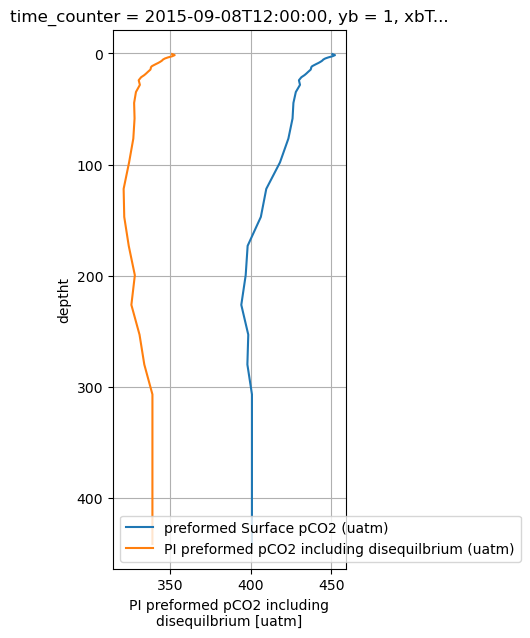

In [23]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ds.preformed_pco2[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:blue',
            label=f'{ds.preformed_pco2.attrs["long_name"]} ({ds.preformed_pco2.attrs["units"]})')                       
ds.PIpref_pco2_inc_diseqpco2[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, 
                                               color='tab:orange',
            label=f'{ds.PIpref_pco2_inc_diseqpco2.attrs["long_name"]} ({ds.PIpref_pco2_inc_diseqpco2.attrs["units"]})')
ax.grid();
ax.legend()
axs[0].plot([340, 485], [30, 30], '--', color='tab:blue');

## Step 7 Find PI preformed DIC (including disequilbrium) ##

In [ ]:
ds = pibc.calculate_preformed_DIC(ds, conversion_uMolar_to_umolkg).  # TO HERE, Function title problems!!!!!

In [ ]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ds.preformed_DIC[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:blue',
                            label=f'{ds.preformed_DIC.attrs["long_name"]} ({ds.preformed_DIC.attrs["units"]})')
ds.preind_pref_dic[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:orange',
                            label=f'{ds.preind_pref_dic.attrs["long_name"]} ({ds.preind_pref_dic.attrs["units"]})')

ax.grid();
ax.legend()
ax.plot([2000, 2100], [30, 30], '--', color='tab:blue');

## Step 8 Find Delta DIC ##

In [ ]:
# Calculate delta DIC
ds['deltaDIC'] = ds.preformed_DIC - ds.preind_pref_dic

In [ ]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ds.deltaDIC[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:green',
                                   );
ax.grid();
ax.plot([0, 40], [30, 30], '--', color='tab:blue');

## Step 9 : Final PI DIC ##

In [ ]:
# find PI DIC
ds['Final_PI_DIC'] = ds.DIC - ds.deltaDIC

In [ ]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ds.DIC[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:blue',
                                   label='DIC now');
ds.Final_PI_DIC[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:orange',
                                    label='PI DIC');

ax.grid();
ax.legend()
ax.set_xlim(1800, 2400)
ax.set_xticks([2000, 2250])
ax.set_ylim(320, 0)
ax.plot([2050, 2300], [30, 30], '--', color='tab:blue');

##  Compare to Tereza's ##

Tereza's value for September 
![title](../../../analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/September.png)

In [ ]:
# plot
tj = xr.open_dataset('../../../analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/preind_DIC/LO_AOUmethod_stoicCO_diseq_allup_y2015m09d08_preind_DIC.nc',
                    group='preindustrial_DIC')

fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ds.DIC[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:blue',
                                   label='DIC now');
ds.Final_PI_DIC[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:orange',
                                    label='PI DIC', linewidth=3);
ax.plot(tj.preind_dic[:, 10], ds.deptht, color='tab:brown',
                          label='TJ PI DIC')
                          
ax.grid();
ax.legend()
ax.plot([2050, 2300], [30, 30], '--', color='tab:blue');

In [ ]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ax.plot(ds.Final_PI_DIC[0, :, 0, 10].values - tj.preind_dic[:, 10].values, -ds.deptht)
ax.set_title("Difference Our Value - Tereza's");
ax.set_xlabel("DIC (uM)");

## Step 10: Correct Near Surface Values

From Tereza's paper or thesis:  
*The cfc tracer method is not appropriate for very young waters, so we do not use it for lower-density waters (σθ <25.0). These lower density waters are typically recently-ventilated waters found near the surface and are likely to be tracking the current atmospheric CO2 concentra- tions. I used a surface intrusion value of 60 mmol m−3 for these waters (σθ <25.0); this estimate is within the range of the reported surface values for the shelf values in the region based on (Feely et al., 2016) and the broader open Pacific (Carter et al., 2019). To avoid discontinuities in the carbon field, for every depth profile I then linearly interpolated from a value of 60 mmol m−3 at surface to the value at σθ =25.0.*

In [ ]:
# check it out
print (ds.Final_PI_DIC[0, :, 0, 10][ds.deptht < 30.06])

In [ ]:
# Calculate: I don't love this, it has a loop
surf_intrusion = 60 # uM
sigma_crit = 25 # Value where we switch from surface intrusion to tracked age
ds = ds.assign(PI_DIC_surfacj= 0 + 1 * ds['Final_PI_DIC'])
ds.PI_DIC_surfacj.attrs['long_name'] = 'PI DIC with Surface Adjustment'
ds.PI_DIC_surfacj.attrs['units'] = 'uM'

depth_crit = np.zeros(ds.sigma.shape[3])
intrusion_at_crit = np.zeros_like(depth_crit)
intrusion_values = np.zeros((ds.sigma.shape[1], ds.sigma.shape[3]))
for ii in range(ds.sigma.shape[3]):
    depth_crit[ii] = np.interp(sigma_crit, ds.sigma[0, :, 0, ii], ds.deptht.values)
    intrusion_at_crit[ii] = np.interp(sigma_crit, ds.sigma[0, :, 0, ii], ds.deltaDIC[0, :, 0, ii])
    intrusion_values[:, ii] = (surf_intrusion * (1 - ds.deptht / depth_crit[ii]) 
                               + intrusion_at_crit[ii] * ds.deptht / depth_crit[ii]);
    kk_crit = np.argmax(ds.deptht.values > depth_crit[ii])
    ds.PI_DIC_surfacj[0, :, 0, ii][ds.deptht < depth_crit[ii]] = (ds.DIC[0, :, 0, ii][ds.deptht < depth_crit[ii]] 
                                                              - intrusion_values[:kk_crit, ii])

In [ ]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15, 2))
colours = axs[0].pcolormesh(depth_crit.reshape(10, 95))
fig.colorbar(colours, ax=axs[0]);
colours = axs[1].pcolormesh(intrusion_at_crit.reshape(10, 95))
fig.colorbar(colours, ax=axs[1]);
for ax in axs:
    ax.plot(10, 0, 'ro');
axs[0].set_title("Depth of sigma=25")
axs[1].set_title("Intrusion at sigma=25")
axs[0].text(20, 2, "Red dot is example cast");

In [ ]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15, 2))
colours = axs[0].pcolormesh(intrusion_values[0].reshape(10, 95))
fig.colorbar(colours, ax=axs[0]);
colours = axs[1].pcolormesh(intrusion_values[20].reshape(10, 95))
fig.colorbar(colours, ax=axs[1]);
for ax in axs:
    ax.plot(10, 0, 'ro');
axs[0].set_title("Intrusion at 0.5 m")
axs[1].set_title(f'Intrusion at {ds.deptht[20].values} m')
axs[0].text(20, 2, "Red dot is example cast");

In [ ]:
# plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
ds['Final_PI_DIC'][0, :, 0, :].plot(y='deptht', yincrease=False, ax=axs[0])
ds['PI_DIC_surfacj'][0, :, 0, :].plot(y='deptht', yincrease=False, ax=axs[1])
(ds['PI_DIC_surfacj'][0, :, 0, :]-ds['Final_PI_DIC'][0, :, 0, :]).plot(y='deptht', yincrease=False, ax=axs[2])

In [ ]:
# check it out
print (ds['PI_DIC_surfacj'][0, :, 0, 10])

In [ ]:
# check it out
print (ds['Final_PI_DIC'][0, :, 0, 10])